# Types de calculs possibles avec bellhop

BELLHOP fait partie de la “Acoustic Toolbox” :
http://oalib.hlsresearch.com/Rays/

Voici le lien pour telecharger le code :
http://oalib.hlsresearch.com/Modes/AcousticsToolbox/


In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.flow import *
from clib.bellhop import *
import subprocess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='med')

## Création des fichiers environnement (.env)

Ici pour le profil de célérité 1, on créé les fichiers environnement (.env) suivant les paramètres choisis :
- La profondeur de la source (*zs*) varie. 
- On a 3 types de fichiers (*file_type*) : 'R' pour les tracés de rayons, 'IB' pour les pertes par propagation et 'A' pour les réponses impulsionnelles en 1 récepteur.
- Pour les tracés de rayons, les calculs sont faits pour des angles entre -15° et +15° (*ALimites*) pour plus de lisibilité.


In [3]:
issp=0                  # sound speed profile number
depth_source = [100.]   # list of chosen source depths

## 'R' files : tracé de rayons
s.params['file_type'] = 'R'
s.params['ALimites'] = [-15.0, 15.0]
for i in depth_source : 
    s.params['zs']=i
    s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=5, \
                        file_env = s.params['name']+'%d_%s.env' \
                        %(issp+1,s.params['file_type']))

## 'IB' files : pertes par propagation    
s.params['file_type'] = 'IB'
s.params['ALimites'] = [-90.0, 90.0]
s.params['NRange'] = 10001
s.params['NDepth'] = 2551
for i in depth_source : 
    s.params['zs']=i
    s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=5, \
                        file_env = s.params['name']+'%d_%s.env' \
                        %(issp+1,s.params['file_type']))


## 'A' files : réponses impulsionnelles    
s.params['file_type'] = 'A'
s.params['ALimites'] = [-90.0, 90.0]
s.params['NRange'] = 101
s.params['NDepth'] = 51
s.params['zmax_receiv']=2000.
for i in depth_source : 
    s.params['zs']=i
    s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=5, \
                        file_env = s.params['name']+'%d_%s.env' \
                        %(issp+1,s.params['file_type']))    

---
---
## Résultats pour le profil 1 (thermocline à 60m) avec la source à 100m

Text(0,0.5,'profondeur (m)')

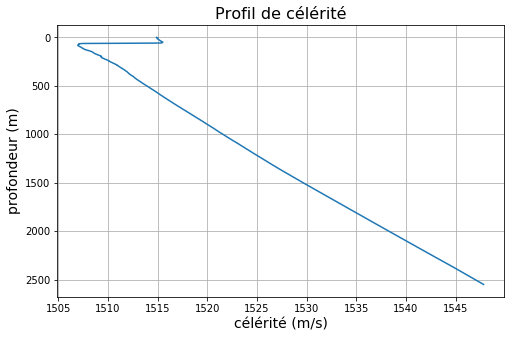

In [4]:
plt.figure(figsize=(8,5))
s.plotssp('mediterrannee', Issp=0, zoom=False)
plt.title('Profil de célérité', fontsize=16)
plt.xlabel('célérité (m/s)', fontsize=14)
plt.ylabel('profondeur (m)', fontsize=14)

In [5]:
### génération du fichier de bathymétrie (.bty), ici pour une bathy contante à 2000m
s.generate_btyfile('med1_IB.env', bathy=2000.)
s.generate_btyfile('med1_R.env', bathy=2000.)
s.generate_btyfile('med1_A.env', bathy=2000.)

 - Une fois les fichiers env et bty créés, il faut executer bellhop dans un terminal : "bellhop.exe med1_R" (ne pas écrire les extensions...)
 - Un fichier de résultat est créé (.ray pour med1_R ; .shd pour med1_IB ; .arr pour med1_A )

---
## Tracé des rayons 

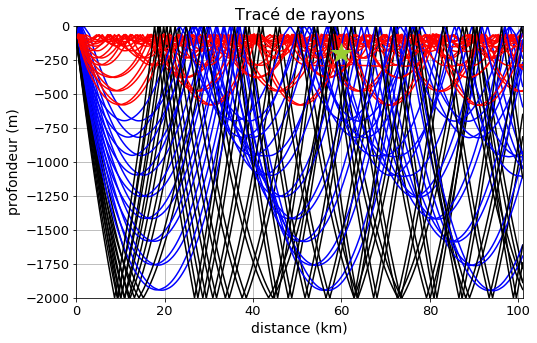

In [6]:
plt.figure(figsize=(8,5))
s.plotray('med1_R.ray')
plt.title('Tracé de rayons', fontsize=16)
plt.xlabel('distance (km)', fontsize = 14)
plt.ylabel('profondeur (m)', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(60., -200., color='yellowgreen', marker='*', markersize=20)
plt.show()
#plt.savefig('rays_example1', dpi=100)

---
## Pertes par propagation 

In [7]:
geometry1, pressure1 = s.readshd('med1_IB.shd')

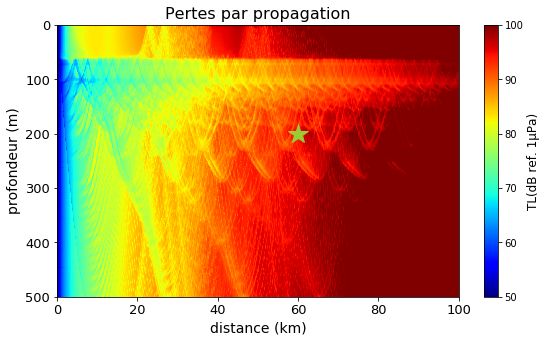

In [8]:
plt.figure(figsize=(9,5))
s.plotshd (geometry1, pressure1)
plt.title ('Pertes par propagation', fontsize=16)
plt.xlabel('distance (km)', fontsize = 14)
plt.ylabel('profondeur (m)', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(60., 200., color='yellowgreen', marker='*', markersize=20)
plt.show()
#plt.savefig('TL_example1', dpi=100)

---
## Réponses impulsionnelles 

In [9]:
Arr, Pos = s.read_arrivals_asc (filename = 'med1_A.arr', Narrmx = 3883)

Max.number of arrivals for source index 0 is 3882


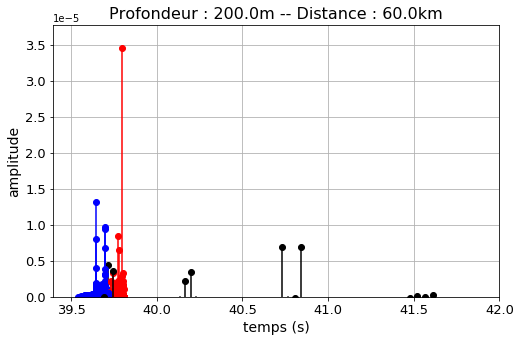

In [10]:
ird = 5        # corresponding depth in Pos['r']['depth'][ird]  
irr = 60       # corresponding range in Pos['r']['range'][irr]
isd = 0

plt.figure(figsize=(8,5))
ax = plt.subplot(111)
Narr = int(Arr['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr['delay'][irr, i, ird, isd]
    markerline, stemlines, baseline = plt.stem( [t], [Arr['A'][irr, i, ird, isd]])            

    if np.logical_and ( Arr['NumTopBnc'][irr, i,ird,isd] == 0, Arr['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')
    elif Arr['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')
    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('temps (s)', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
plt.title('Profondeur : %.1fm -- Distance : %.1fkm' %(Pos['r']['depth'][ird], \
                                              Pos['r']['range'][irr]/1000.), fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.xlim(xmax=42.)
plt.show()
#plt.savefig('arr_example', dpi=100)